<a href="https://colab.research.google.com/github/bpmuc/SharingIsCaring/blob/main/UNet_7_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Implementation for AFP Defects Segmentation

In [1]:

# Install necessary libraries
!pip install tensorflow tensorflow-addons

# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

from tensorflow.keras.regularizers import l2



import cv2

# Mount Google Drive
drive.mount('/content/drive')

# Paths to images and masks
image_path = '/content/drive/MyDrive/data/images'
mask_path = '/content/drive/MyDrive/data/masks'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
Mounted at /content/drive


In [2]:
def iou(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    intersection = K.sum(K.cast(y_true == y_pred, 'float32'))
    union = K.sum(K.cast(K.greater(y_true + y_pred, 0), 'float32'))
    return intersection / (union + K.epsilon())

def load_images_and_masks(image_path, mask_path, image_size=(256, 256), num_classes=3):
    images = []
    masks = []
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_path) if f.endswith('.png')])

    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(image_path, img_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_path, mask_file), cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, image_size) / 255.0
        mask = cv2.resize(mask, image_size)

        # Normalize mask values to fit the number of classes
        mask = np.clip(mask, 0, num_classes - 1)

        images.append(img)
        masks.append(mask)

    images = np.array(images).reshape(-1, image_size[0], image_size[1], 1)
    masks = np.array(masks).reshape(-1, image_size[0], image_size[1])

    # Convert masks to categorical (one-hot encoded)
    masks = np.array([to_categorical(mask, num_classes=num_classes) for mask in masks])

    return images, masks



# Prepare data
images, masks = load_images_and_masks(image_path, mask_path)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.3, random_state=42)








# Data augmentation parameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=15,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

# Create ImageDataGenerator for images and masks
image_datagen = ImageDataGenerator(**data_gen_args)
#mask_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(preprocessing_function=lambda x: to_categorical(x, num_classes=3))


# Fit the generators on the training data
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Combine generators to ensure both images and masks are augmented in the same way
def train_generator(batch_size):
    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)
    while True:
        img = image_generator.next()
        mask = mask_generator.next()
        yield img, mask


In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf



# Ensure masks are one-hot encoded, and flatten to get class labels
y_flat = masks.argmax(axis=-1).flatten()

# Convert unique_classes to a NumPy array
unique_classes = np.array([0, 1, 2])  # Background, class 1, class 2

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_flat)

# Create a dictionary for weights
class_weights_dict = {i: class_weights[i] for i in unique_classes}

print("Class Weights:", class_weights_dict)






# Define weighted categorical crossentropy loss
def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        return CategoricalCrossentropy()(y_true, y_pred) * tf.reduce_sum(weights * y_true, axis=-1)
    return loss

# Define U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder


    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(0.001))(inputs)  # Add L2 regularization
    conv1 = Dropout(0.1)(conv1)  # Add dropout with a rate of 10%
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    outputs = Conv2D(3, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=weighted_categorical_crossentropy(class_weights), metrics=['accuracy'])

    return model


Class Weights: {0: 0.37166310622332194, 1: 5.368140416919917, 2: 8.1230137930989}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├──────────────────────

 Total params: 7,696,323 (29.36 MB)

 Trainable params: 7,696,323 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 8s/step - accuracy: 0.8195 - loss: 0.8487 - val_accuracy: 0.9049 - val_loss: 0.3899
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 684ms/step - accuracy: 0.8974 - loss: 0.4251 - val_accuracy: 0.9049 - val_loss: 0.3880
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step - accuracy: 0.8953 - loss: 0.4326 - val_accuracy: 0.9049 - val_loss: 0.3775
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 615ms/step - accuracy: 0.8841 - loss: 0.4896 - val_accuracy: 0.9049 - val_loss: 0.3679
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 710ms/step - accuracy: 0.8953 - loss: 0.4162 - val_accuracy: 0.9049 - val_loss: 0.3663
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step - accuracy: 0.8948 - loss: 0.4201 - val_accuracy: 0.9049 - val_loss: 0.3523
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step - accuracy: 0.8950 - loss: 0.4114 - val_accuracy: 0.9049 - val_loss: 0.3478
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step - accuracy: 0.8892 - loss: 0.4238 - val_accuracy: 0.9049 - v

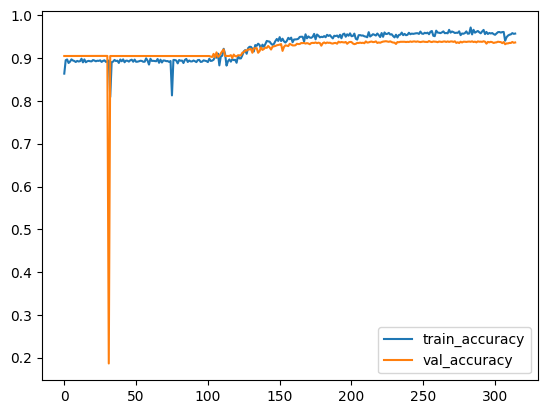

In [4]:
batch_size = 16
def train_generator(batch_size):
    seed = 1
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

    while True:
        img = next(image_generator)  # Use `next()` here
        mask = next(mask_generator)  # Use `next()` here
        yield img, mask
# Initialize and compile the model
model = unet_model()
model.summary()



# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Watch validation loss
    patience=100,           # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Revert to the best weights
)

# Train the model with early stopping
history = model.fit(
    train_generator(batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=500,             # Maximum number of epochs
    callbacks=[early_stopping],  # Include early stopping
    verbose=1
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


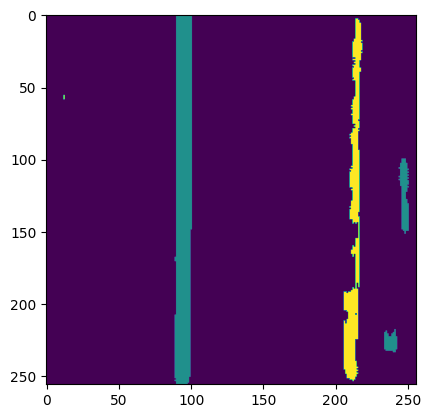

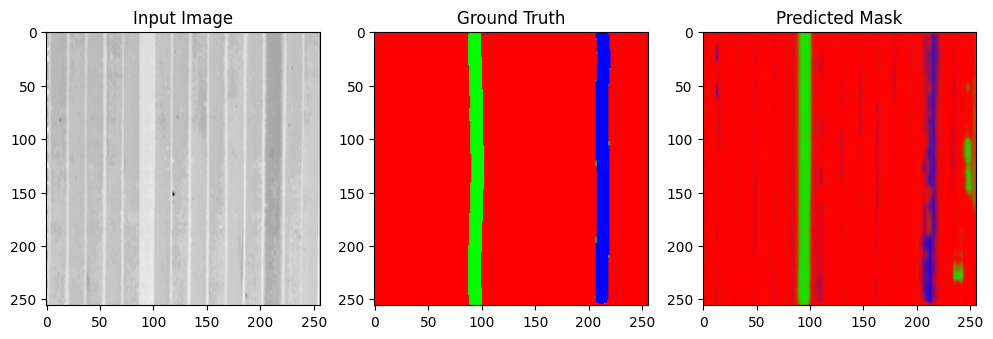

In [5]:


# Predict on a sample image
sample_image = X_val[12]
sample_mask = y_val[12]
predicted_mask = model.predict(sample_image[np.newaxis, ...])[0]

predicted_class = np.argmax(predicted_mask, axis=-1)  # Get class with highest probability

# Display predictions
plt.imshow(predicted_class, cmap='viridis')  # Use a colormap suitable for multi-class


# Display sample image, ground truth, and prediction
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Input Image')
plt.imshow(sample_image.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Ground Truth')
plt.imshow(sample_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


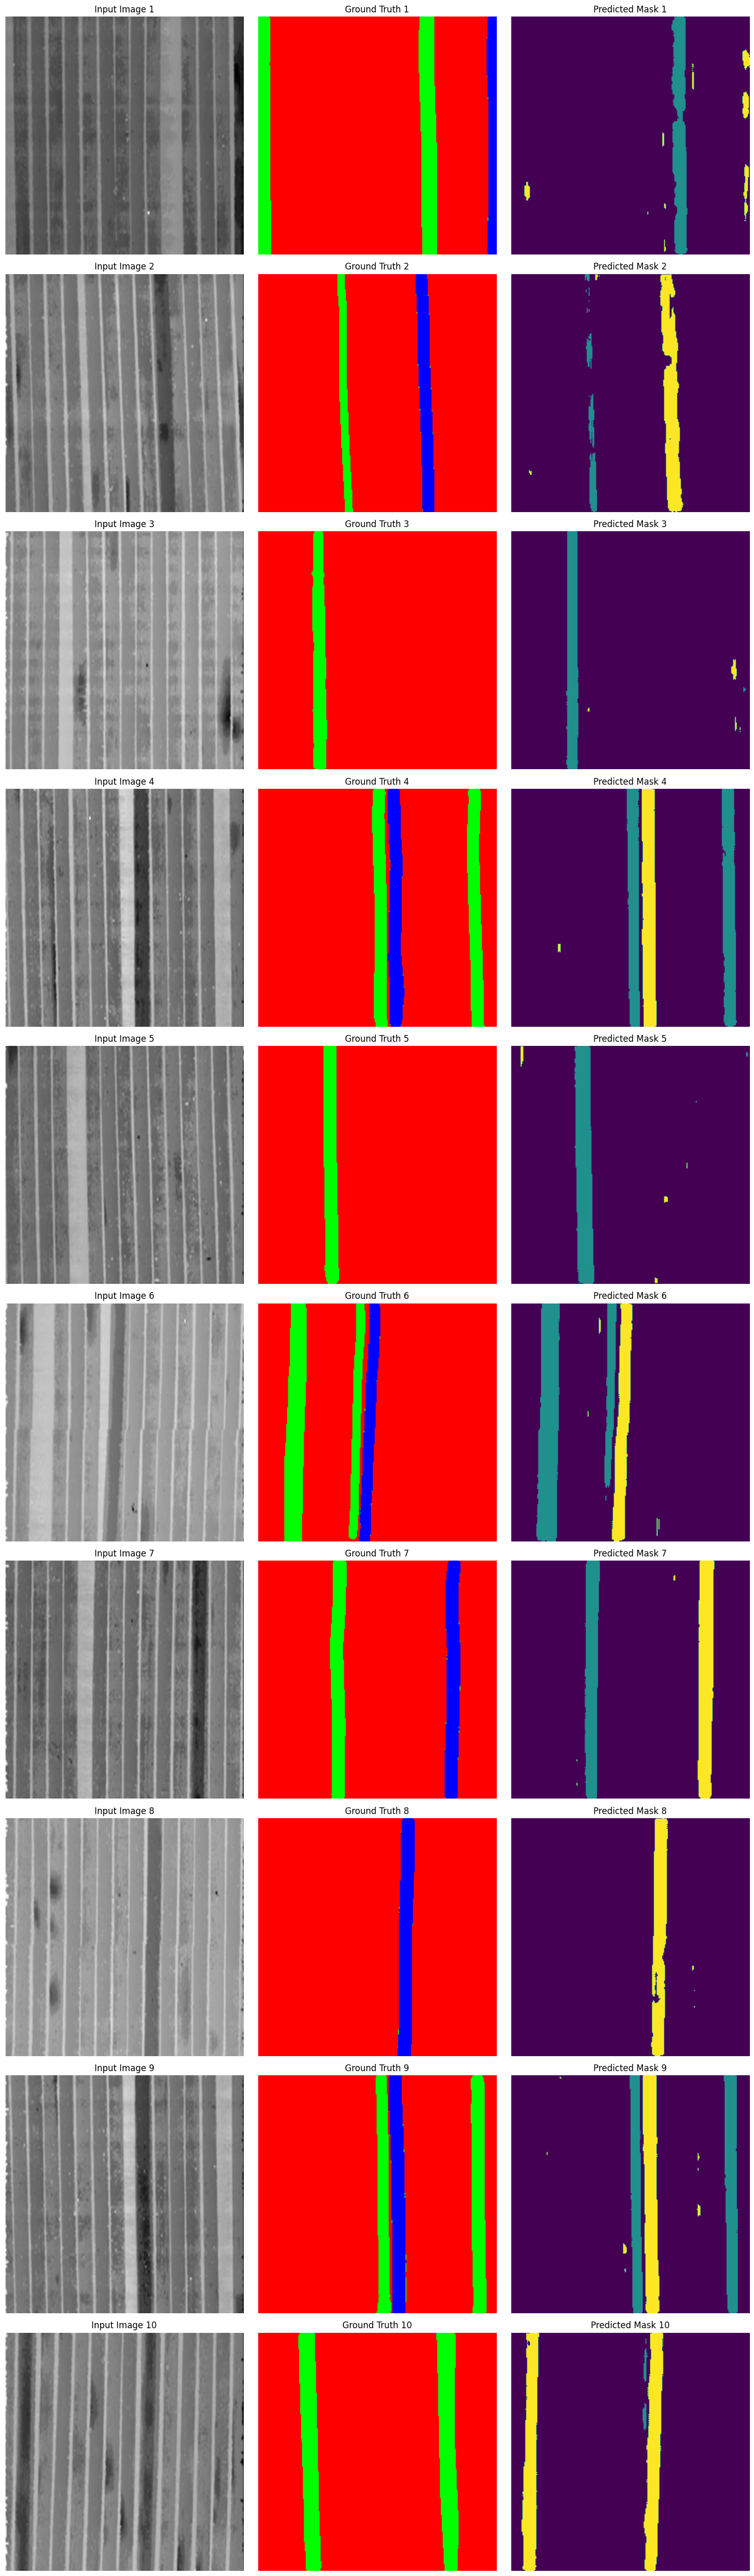

In [6]:


def visualize_validation_results(X_val, y_val, model, num_samples=None):
    """
    Visualize predictions for the entire validation dataset or a subset of it.

    Args:
        X_val (numpy.ndarray): Validation images.
        y_val (numpy.ndarray): Ground truth masks.
        model (keras.Model): Trained model.
        num_samples (int): Number of samples to display. If None, displays all.
    """
    num_samples = num_samples or len(X_val)
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        sample_image = X_val[i]
        sample_mask = y_val[i]
        predicted_mask = model.predict(sample_image[np.newaxis, ...])[0]
        predicted_class = np.argmax(predicted_mask, axis=-1)

        # Subplots for each sample
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f"Input Image {i + 1}")
        plt.imshow(sample_image.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title(f"Ground Truth {i + 1}")
        plt.imshow(sample_mask.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title(f"Predicted Mask {i + 1}")
        plt.imshow(predicted_class.squeeze(), cmap='viridis')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize all validation results
visualize_validation_results(X_val, y_val, model, num_samples=10)  # Display the first 10 results


## Data Augmentation

In [ ]:

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.tensorflow import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.Rotate(limit=30, p=0.5),
    ToTensorV2()
])

def augment_image(image, mask):
    augmented = train_transform(image=image, mask=mask)
    return augmented['image'], augmented['mask']


## Residual Block

In [ ]:

from tensorflow.keras.layers import Add

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Add()([x, shortcut])  # Residual connection
    return x


## Attention Block

In [ ]:

from tensorflow.keras.layers import Multiply, Activation

def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, kernel_size=(1, 1), strides=(1, 1))(x)
    phi_g = Conv2D(inter_channels, kernel_size=(1, 1), strides=(1, 1))(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi = Activation('sigmoid')(Conv2D(1, kernel_size=(1, 1))(f))
    return Multiply()([x, psi])


## Learning Rate Scheduler

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
callbacks = [EarlyStopping(patience=10, restore_best_weights=True), lr_scheduler]


## Weighted Loss Function

In [ ]:

from tensorflow.keras.losses import CategoricalCrossentropy

def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        return tf.reduce_sum(CategoricalCrossentropy()(y_true, y_pred) * weights)
    return loss

weights = [0.5, 1.5, 2.0]  # Example weights for classes
loss_function = weighted_categorical_crossentropy(weights)
model.compile(optimizer='adam', loss=loss_function, metrics=['accuracy'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


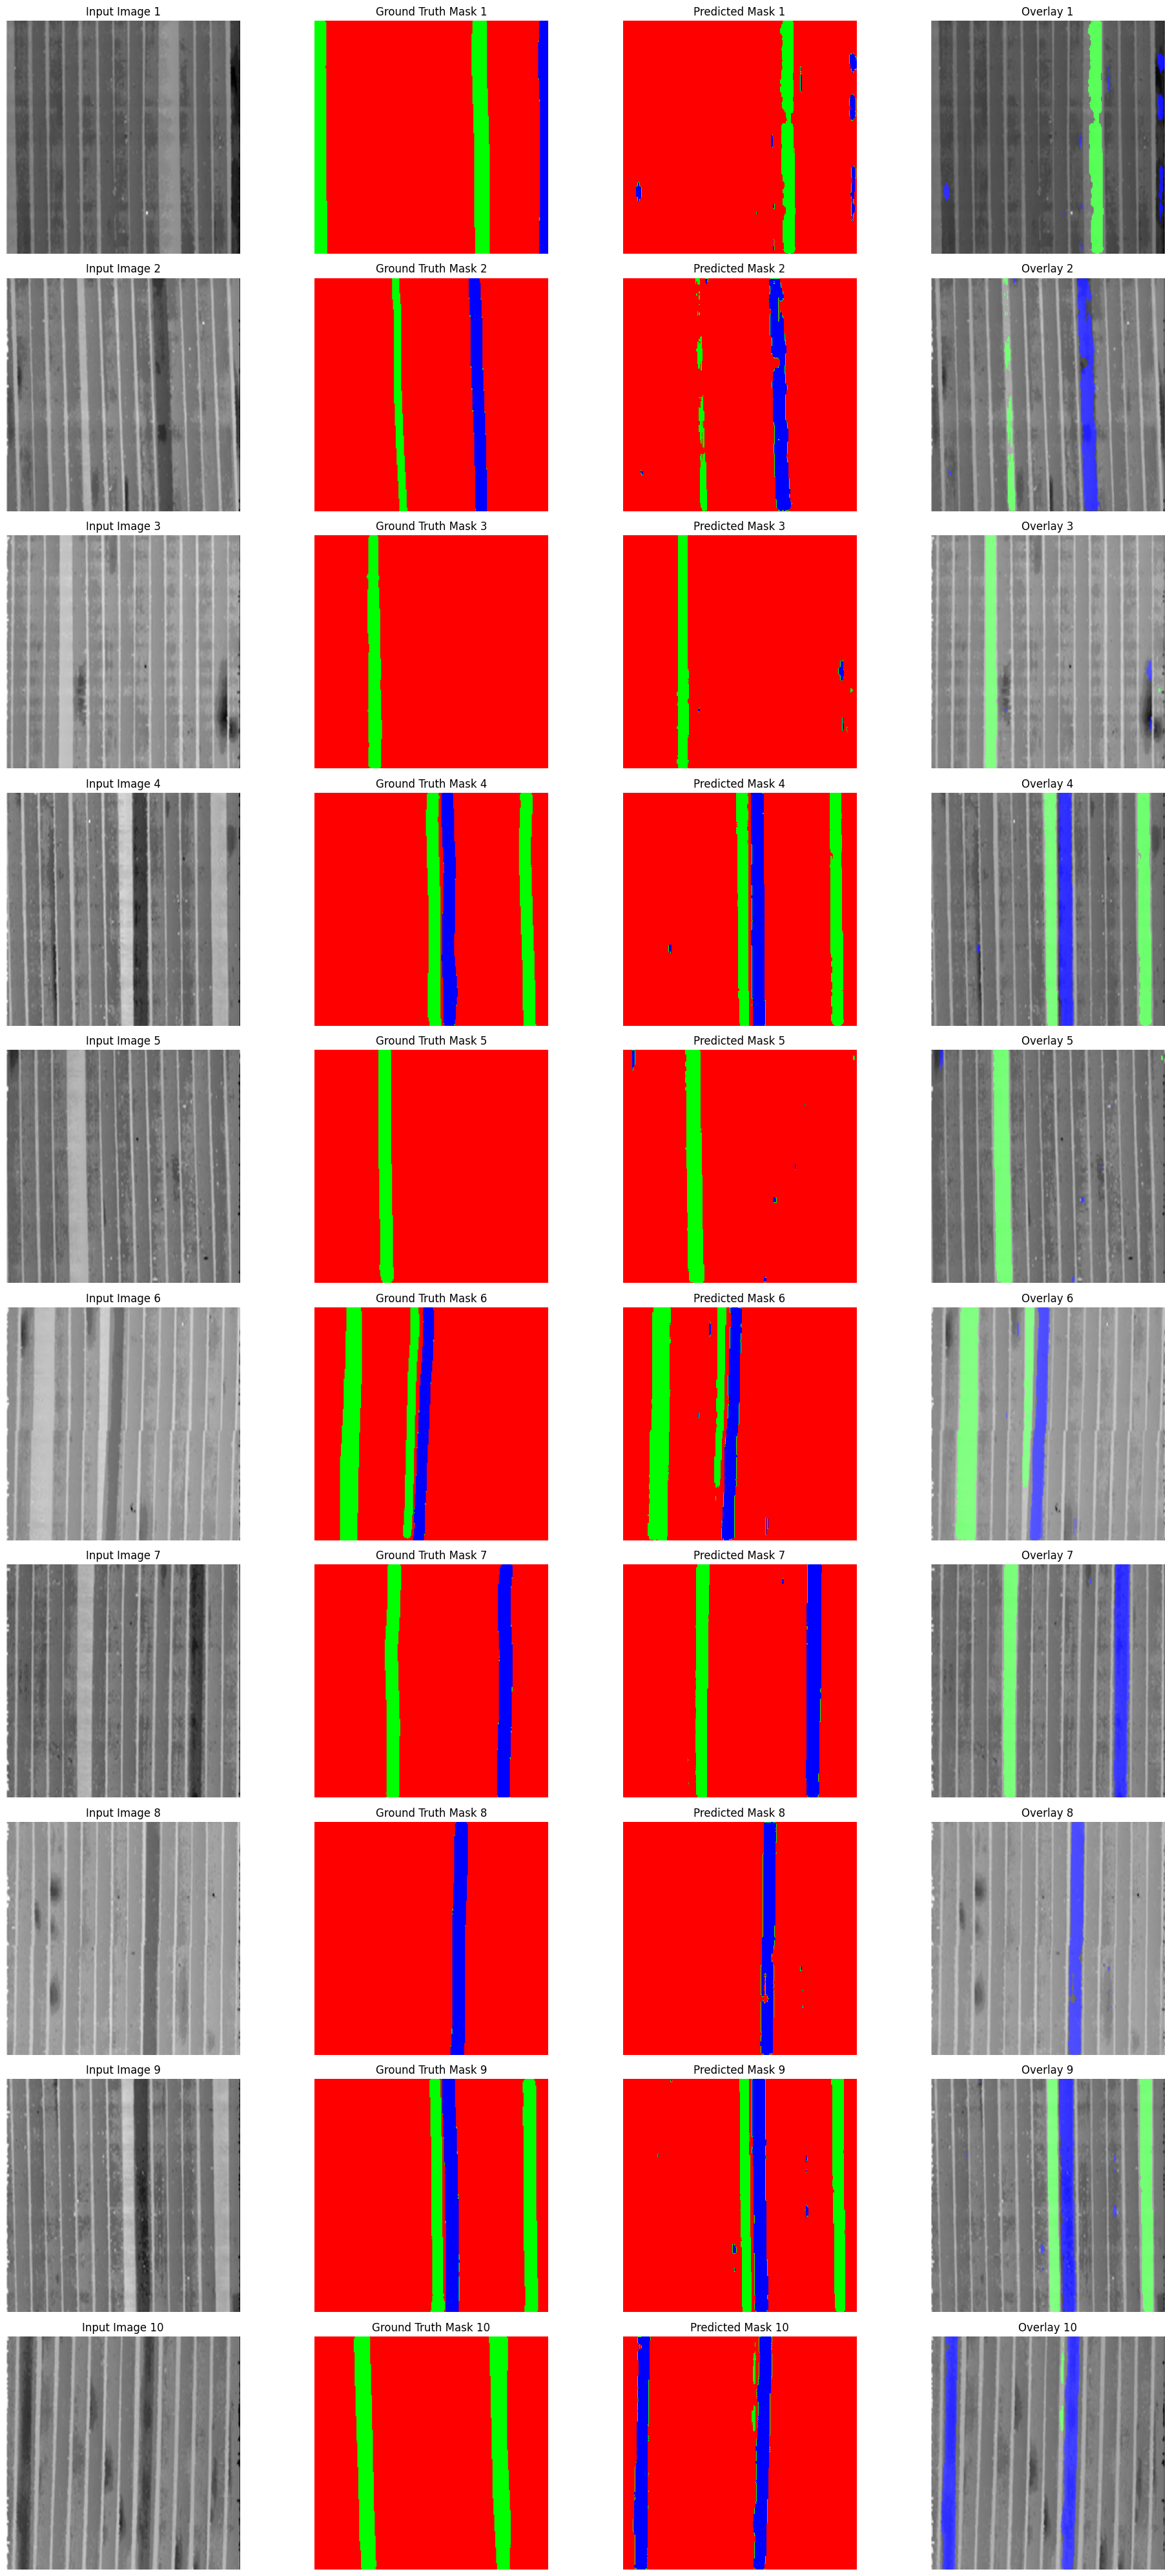

In [22]:
import matplotlib.colors as mcolors

def visualize_validation_results(X_val, y_val, model, num_samples=None):
    """
    Visualize predictions for the entire validation dataset or a subset of it.

    Args:
        X_val (numpy.ndarray): Validation images.
        y_val (numpy.ndarray): Ground truth masks.
        model (keras.Model): Trained model.
        num_samples (int): Number of samples to display. If None, displays all.
    """
    num_samples = num_samples or len(X_val)
    plt.figure(figsize=(20, 4 * num_samples))

    # Explicit RGB colors for masks
    red = (1, 0, 0)       # Category 0
    green = (0, 1, 0)     # Category 1
    blue = (0, 0, 1)      # Category 2

    # Colormap for ground truth and predicted masks
    cmap = mcolors.ListedColormap([red, green, blue])
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5], ncolors=3)

    for i in range(num_samples):
        sample_image = X_val[i]
        sample_mask = y_val[i]
        predicted_mask = model.predict(sample_image[np.newaxis, ...])[0]
        predicted_class = np.argmax(predicted_mask, axis=-1)

        # Subplot for the input image
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.title(f"Input Image {i + 1}")
        plt.imshow(sample_image.squeeze(), cmap='gray')
        plt.axis('off')

        # Subplot for the ground truth mask
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.title(f"Ground Truth Mask {i + 1}")
        plt.imshow(sample_mask.squeeze(), cmap=cmap, norm=norm)
        plt.axis('off')

        # Subplot for the predicted mask
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.title(f"Predicted Mask {i + 1}")
        plt.imshow(predicted_class.squeeze(), cmap=cmap, norm=norm)
        plt.axis('off')

        # Subplot for overlay (original image with predicted mask categories 1 and 2)
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.title(f"Overlay {i + 1}")

        # Prepare overlay: only highlight categories 1 and 2
        sample_image_rgb = np.stack([sample_image.squeeze()] * 3, axis=-1)  # Convert grayscale to RGB
        overlay = sample_image_rgb.copy()

        # Explicitly set the same RGB values as used in the colormap
        mask_1 = predicted_class.squeeze() == 1  # Category 1
        mask_2 = predicted_class.squeeze() == 2  # Category 2

        overlay[mask_1] = [0, 255, 0]  # Green (matching colormap)
        overlay[mask_2] = [0, 0, 255]  # Blue (matching colormap)

        # Blend overlay with the original image
        blended = cv2.addWeighted(sample_image_rgb, 0.7, overlay, 0.3, 0)

        plt.imshow(blended)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to visualize all validation results
visualize_validation_results(X_val, y_val, model, num_samples=10)  # Display the first 10 results
